In [37]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv

def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

svg_file = './data/problems/frag0.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])


defaultdict(<class 'list'>, {0: [(np.float64(42.282666666666636), np.float64(69.33033333333334)), (np.float64(24.879349361382413), np.float64(113.25390232907588))], 1: [(np.float64(24.879349361382413), np.float64(113.25390232907588)), (np.float64(36.89100000000001), np.float64(157.808))], 2: [(np.float64(176.5), np.float64(67.5)), (np.float64(153.66719283643496), np.float64(44.950373247833916))], 3: [(np.float64(153.66719283643496), np.float64(44.950373247833916)), (np.float64(121.20065848465265), np.float64(35.57279582066971))], 4: [(np.float64(121.20065848465265), np.float64(35.57279582066971)), (np.float64(77.20529629629624), np.float64(43.384074074074086))], 5: [(np.float64(77.20529629629624), np.float64(43.384074074074086)), (np.float64(42.282666666666636), np.float64(69.33033333333334))], 6: [(np.float64(36.89100000000001), np.float64(157.808)), (np.float64(63.655899453673555), np.float64(182.66043734147925))], 7: [(np.float64(63.655899453673555), np.float64(182.66043734147925)),

C:\Users\shubh\AppData\Local\Temp\ipykernel_21268\3586970264.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


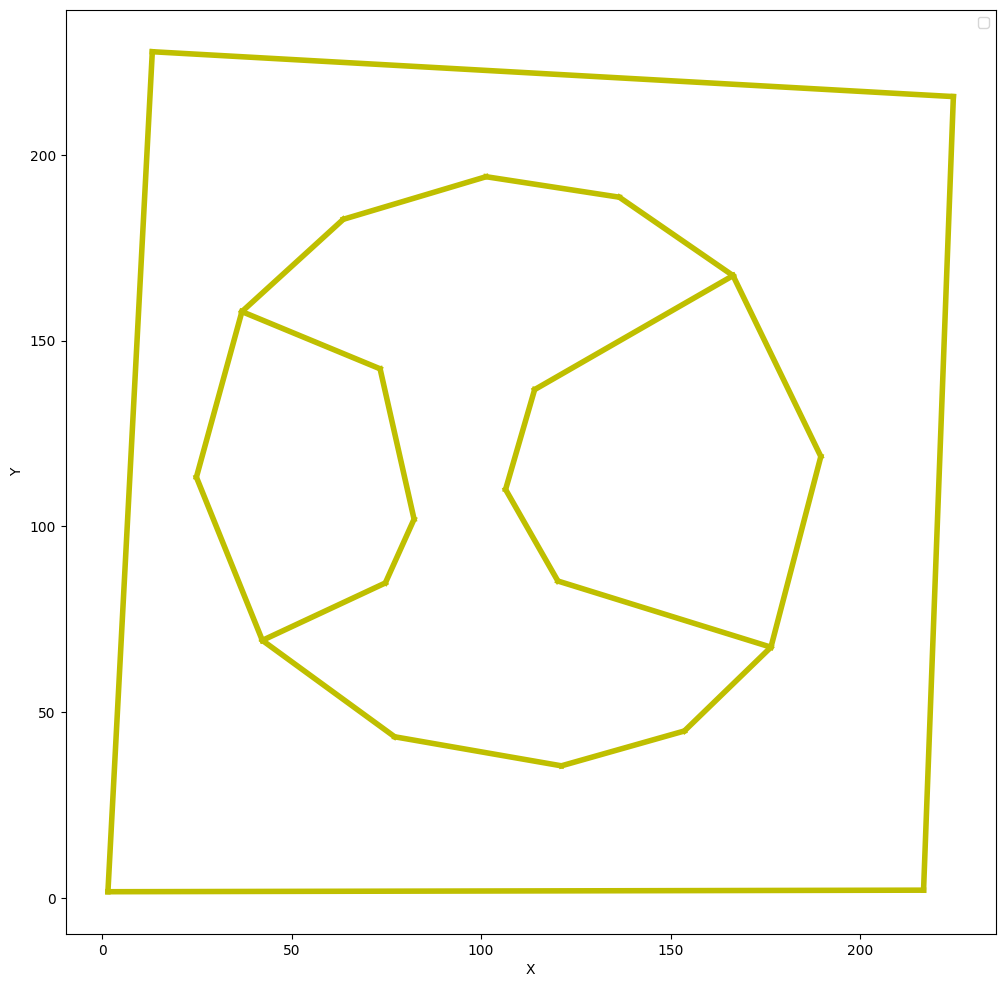

In [38]:
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    return np.linalg.norm(point1 - point2)

def rdp(points: np.ndarray, epsilon: float) -> List[Tuple[float, float]]:
    dmax = 0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = euclidean_distance(points[i], points[0]) + euclidean_distance(points[i], points[-1]) - euclidean_distance(points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        results1 = rdp(points[:index + 1], epsilon)
        results2 = rdp(points[index:], epsilon)
        return results1[:-1] + results2
    else:
        return [tuple(points[0]), tuple(points[-1])]

def average_close_vertices(curves: defaultdict, tolerance: float) -> defaultdict:
    all_points = []
    for points in curves.values():
        all_points.extend(points)

    clusters = []
    for point in all_points:
        added = False
        for cluster in clusters:
            if any(euclidean_distance(np.array(cp), np.array(point)) <= tolerance for cp in cluster):
                cluster.append(point)
                added = True
                break
        if not added:
            clusters.append([point])

    averaged_points = {}
    for cluster in clusters:
        avg_point = tuple(np.mean(cluster, axis=0))
        for point in cluster:
            averaged_points[point] = avg_point

    new_curves = defaultdict(list)
    for curve_no, points in curves.items():
        new_points = [averaged_points[point] for point in points]
        new_curves[curve_no] = new_points

    return new_curves

def convert_polylines_to_lines(curves: defaultdict) -> defaultdict:
    new_curves = defaultdict(list)
    line_index = 0
    for curve_no, points in curves.items():
        if len(points) > 1:
            for i in range(len(points) - 1):
                new_curves[line_index].append(points[i])
                new_curves[line_index].append(points[i + 1])
                line_index += 1
    return new_curves

def are_collinear(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float], tol: float = 0.5) -> bool:
    area = p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
    return abs(area) < tol

def slope(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return (p2[1] - p1[1]) / (p2[0] - p1[0]) if (p2[0] - p1[0]) != 0 else float('inf')

def merge_collinear_lines(curves: defaultdict, slope_tol: float = 0.5, dist_tol: float = 0.5) -> defaultdict:
    merged_lines = defaultdict(list)
    lines = []
    
    for points in curves.values():
        for i in range(0, len(points), 2):
            lines.append((points[i], points[i+1]))

    merged = [False] * len(lines)

    for i in range(len(lines)):
        # if merged[i]:
        #     continue
        line1 = lines[i]
        p1, p2 = line1
        merged_lines[len(merged_lines)] = [p1, p2]
        for j in range(i + 1, len(lines)):
            # if merged[j]:
            #     continue
            line2 = lines[j]
            q1, q2 = line2
            if are_collinear(p1, p2, q1) and are_collinear(p1, p2, q2):
                if (euclidean_distance(np.array(p2), np.array(q1)) <= dist_tol or
                    euclidean_distance(np.array(p2), np.array(q2)) <= dist_tol):
                    merged[i] = True
                    merged[j] = True
                    p2 = q2 if euclidean_distance(np.array(p2), np.array(q2)) < euclidean_distance(np.array(p2), np.array(q1)) else q1
                    merged_lines[len(merged_lines)-1] = [p1, p2]

    return merged_lines

curves = defaultdict(list)

# Load the CSV data
with open('out.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

epsilon_initial = 1.5  
simplified_curves = defaultdict(list)
for curve_no, points in curves.items():
    points_array = np.array(points)
    simplified_points = rdp(points_array, epsilon_initial)
    simplified_curves[curve_no] = simplified_points

simplified_curves = convert_polylines_to_lines(simplified_curves)

tolerance = 5
averaged_curves = average_close_vertices(simplified_curves, tolerance)

epsilon_final = 1.5 
final_curves = defaultdict(list)
for curve_no, points in averaged_curves.items():
    points_array = np.array(points)
    final_points = rdp(points_array, epsilon_final)
    final_curves[curve_no] = final_points

final_curves = convert_polylines_to_lines(final_curves)
final_curves = merge_collinear_lines(final_curves)

print(final_curves)

plt.figure(figsize=(12, 12))
for curve_no, points in final_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, linewidth=4, color="y")

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
